## Imports

In [21]:
# data pre-processing
import pickle
import numpy as np
import pandas as pd
from epiweeks import Week
from datetime import timedelta
import os

# pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = [16,8]

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# custom functions
import sys
sys.path.append(r"C:\Users\User\Documents\projects\LHL_final_project_influenza_forecasting\src")
from evaluate_model import *
from prediction_intervals import *

# Interactivity
from ipywidgets import interact, widgets

# Visualization

# Plotly
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly_express as px

# cufflinks is a wrapper on plotly
import cufflinks as cf
cf.go_offline(connected=True)

## Add New Data

In [2]:
# add new data

# new_data = {'Surveillance Week':[47],
#             'A(H1N1)pdm09':[119],
#             'A(H3N2)':	[2214],
#             'A(Unsubtyped)':[5424],
#             'Influenza B':[16],
#             'Percent Positive A':[23.1],
#             'Percent Positive B':[0.0]}

In [3]:
# add new data

# new_data_df = pd.DataFrame.from_dict(new_data)
# new_data_df = new_data_df.iloc[:,0:5]
# for i in range(len(new_data_df)):
#     if int(new_data_df['Surveillance Week'][i]) >= 35 & int(new_data_df['Surveillance Week'][i]) <= 53:
#         new_data_df['Year'] = "2022"
#     else:
#         new_data_df['Year'] = "2023"

# sum_list = new_data_df.columns[1:5]
# new_data_df['Total Cases'] = new_data_df[sum_list].sum(axis=1)
# new_data_df['Surveillance Week'] = new_data_df['Surveillance Week'].astype(int).astype(str)
# new_data_df['Surveillance Week'] = new_data_df['Surveillance Week'].str.pad(2, fillchar='0')
# new_data_df['Year'] = new_data_df['Year'].astype(int).astype(str)
# new_data_df['Epiweek'] = new_data_df['Year'] + new_data_df['Surveillance Week'].astype(str)
# new_data_df['Week Ending'] = new_data_df['Epiweek'].apply(lambda x: Week.fromstring(x).enddate())
# new_data_df['Week Ending'] = pd.to_datetime(new_data_df['Week Ending'], format="%Y-%m-%d")

# df_flu = pickle.load(open(r"..\data\flu_cases\df_flu.pkl", "rb" ))
# # df_flu = pd.concat([df_flu, new_data_df], axis=0)
# # df_flu = df_flu.reset_index(drop=True)
# df_flu.loc[len(df_flu.index)] = np.nan
# df_flu['Week Ending'].iloc[-1] = df_flu['Week Ending'].iloc[-2] + timedelta(weeks=1)
# df_flu['Week Ending'].iloc[-1]
# pickle.dump(df_flu, open(r"..\data\flu_cases\df_flu.pkl", "wb" ))
# df_flu = df_flu[['Week Ending', 'Total Cases']]
# df_flu = df_flu.set_index('Week Ending')
# pickle.dump(df_flu, open(r"..\data\flu_cases\df_flu_total.pkl", "wb" ))

## Feature Engineering

#### Time Series Features

In [2]:
# use existing data
df_flu = pickle.load(open(r"..\data\flu_cases\df_flu_total.pkl", "rb" ))

# add next three weeks to predict as well
df_flu['y2'] = df_flu['Total Cases'].shift(-1)
df_flu['y3'] = df_flu['Total Cases'].shift(-2)
df_flu['y4'] = df_flu['Total Cases'].shift(-3)
df_flu.rename(columns={'Total Cases':'y1'}, inplace=True)

# extract year, month and week
# df_flu = df_flu.set_index('Week Ending')
df_flu['year'] = df_flu.index.year
df_flu['month'] = df_flu.index.month

# df_flu['week'] = df_flu.index.isocalendar().week

# add season
season_dict = {
    1:'Winter',
    2:'Winter',
    3:'Spring',
    4:'Spring',
    5:'Spring',
    6:'Summer',
    7:'Summer',
    8:'Summer',
    9:'Fall',
    10:'Fall',
    11:'Fall',
    12:'Winter'}
df_flu["season"] = df_flu["month"].map(season_dict)

# include 7 lag features (based on autocorrelation plot showing significant autocorrelation for 7 previous values)
arr_list = []
for i in range(1,8):
    arr_list.append(df_flu['y1'].shift(i).to_numpy())

col_names = [*range(1,8)]
new_col_names = []
for name in col_names:
    name = 't - ' + str(name)
    new_col_names.append(name)
df = pd.DataFrame.from_dict(dict(zip(new_col_names, arr_list)))
df_flu = df_flu.reset_index()
df_flu = pd.concat([df_flu, df], axis=1)

# same week from previous year
df_flu['this week last year'] = df_flu['y1'].shift(52)

# use 2-week moving average (based on EDA - simplifies the pattern without losing too much data)
df_flu['two-week moving average'] = df_flu['t - 1'].rolling(window=2).mean()

# expanding mean
df_flu['expanding mean'] = df_flu['t - 1'].expanding().mean()

pickle.dump(df_flu, open(r"..\data\flu_cases\df_time_features.pkl", "wb" ))

#### Health Indicators

In [3]:
# get health indicators
df_indicators = pd.read_csv(r'..\data\health_indicators\health_indicators_2015_2021.csv', skiprows=12)

# Drop nulls because they are only showing on the rows without data
df_indicators.dropna(inplace=True)

# Null values in the data are represented with '..'
df_indicators = df_indicators.replace('..', np.nan)
df_indicators = df_indicators.T
more_than_half_missing = df_indicators.isnull().sum() >= 4
more_than_half_missing = pd.DataFrame(more_than_half_missing)
idx_to_drop = list(more_than_half_missing[more_than_half_missing[0]==True].index.values)

# drop rows
df_indicators = df_indicators.T
df_indicators = df_indicators.drop(index=idx_to_drop)
df_indicators = df_indicators.reset_index(drop=True)

# convert values to numeric values
df_indicators = df_indicators.replace(',','', regex=True)
df_indicators = df_indicators.set_index('Indicators')
df_indicators = df_indicators.apply(pd.to_numeric)

# fill nulls with the mean value from the row
df_indicators = df_indicators.apply(lambda row: row.fillna(row.mean()), axis=1)
df_indicators.reset_index()
df_indicators = df_indicators.T
df_indicators = df_indicators.reset_index()
df_indicators['index'] = df_indicators['index'].astype(int)

# add a row for 2022 and shift all the values forward one year because we will use previous year's value to predict current years flu cases
df_indicators.loc[len(df_indicators.index)] = 2022
df_indicators.iloc[:,1:] = df_indicators.iloc[:,1:].shift(1)

# merge health indicators with df_flu
df_flu = pickle.load(open(r"..\data\flu_cases\df_flu_total.pkl", "rb" ))

years = [x.year for x in df_flu.index]

X = np.array([years]).T
dates = pd.DataFrame(X, columns = ['year'])

df_flu = df_flu.reset_index(drop=True)
df_flu = pd.concat([dates, df_flu], axis=1)

df_health_indicators = pd.merge(df_flu, df_indicators, how='left', left_on=['year'], right_on=['index'])

pickle.dump(df_health_indicators, open(r"..\data\health_indicators\df_health_indicators.pkl", "wb" ))

#### Google Trends - Flu Symptom Search Terms

In [4]:
# get a list of table names
table_list_flu = os.listdir(r"..\data\google_trend\flu")

# create a dictionary with table names as keys and dataframes as values
dict_flu = {}
datapath = r'..\data\google_trend\flu'

for i in range(len(table_list_flu)):
    df = pd.read_csv(datapath+'\\'+table_list_flu[i], header=1)
    dict_flu[table_list_flu[i][13:-4]] = df

# create a dataframe with one column for each symptom
df_flu_symptoms = pd.DataFrame({'Month':dict_flu['body_aches']['Month']}) # get the month values from one of the dataframes
df_flu_symptoms.loc[len(df_flu_symptoms.index)] = '2022-12'

for key in dict_flu:
    df_flu_symptoms[key] = dict_flu[key].iloc[:,1] # retrieve values from each dataframe

df_flu_symptoms.iloc[:,1:] = df_flu_symptoms.iloc[:,1:].shift(1)

df_flu_symptoms['Month'] = pd.to_datetime(df_flu_symptoms['Month'])
df_flu_symptoms.set_index('Month', inplace=True)

# get month and year to be able to merge with df_flu
months = [x.month for x in df_flu_symptoms.index]
years = [x.year for x in df_flu_symptoms.index]
X = np.array([months, years]).T
dates = pd.DataFrame(X, columns = ['month', 'year'])
df_flu_symptoms = df_flu_symptoms.reset_index(drop=True)
df_flu_symptoms = pd.concat([dates, df_flu_symptoms], axis=1)

# merge flu symptoms with df_flu
df_flu = pickle.load(open(r"..\data\flu_cases\df_flu_total.pkl", "rb" ))

months = [x.month for x in df_flu.index]
years = [x.year for x in df_flu.index]
weeks = [x.weekofyear for x in df_flu.index]

X = np.array([months, years, weeks]).T
df = pd.DataFrame(X, columns = ['month', 'year', 'week'])

df_flu = df_flu.reset_index(drop=True)
new = pd.concat([df_flu, df], axis=1)

df_flu_symptoms = pd.merge(new, df_flu_symptoms, how='left', on=['month','year'])

pickle.dump(df_flu_symptoms, open(r"..\data\google_trend\df_flu_symptoms.pkl", "wb" ))

#### Google Trends - COVID Search Terms

In [5]:
# get a list of table names
table_list_COVID = os.listdir(r"..\data\google_trend\COVID")

# create a dictionary with table names as keys and dataframes as values
dict_COVID = {}
datapath = r'..\data\google_trend\COVID'

for i in range(len(table_list_COVID)):
    df = pd.read_csv(datapath+'\\'+table_list_COVID[i], header=1)
    dict_COVID[table_list_COVID[i][13:-4]] = df

# create a dataframe with one column for each symptom
df_COVID_terms = pd.DataFrame({'Month':dict_COVID['coronavirus']['Month']})
df_COVID_terms.loc[len(df_COVID_terms.index)] = '2022-12'

for key in dict_COVID:
    df_COVID_terms[key] = dict_COVID[key].iloc[:,1]

df_COVID_terms.iloc[:,1:] = df_COVID_terms.iloc[:,1:].shift(1)

df_COVID_terms = df_COVID_terms.replace('<1',0.5)

df_COVID_terms[['coronavirus', 'COVID', 'social_distancing']] = df_COVID_terms[['coronavirus', 'COVID', 'social_distancing']].apply(pd.to_numeric)

df_COVID_terms['Month'] = pd.to_datetime(df_COVID_terms['Month'])
df_COVID_terms.set_index('Month', inplace=True)

# get month and year to be able to merge with df_flu
months = [x.month for x in df_COVID_terms.index]
years = [x.year for x in df_COVID_terms.index]
X = np.array([months, years]).T
dates = pd.DataFrame(X, columns = ['month', 'year'])
df_COVID_terms = df_COVID_terms.reset_index(drop=True)
df_COVID_terms = pd.concat([dates, df_COVID_terms], axis=1)

# merge COVID symptoms with df_flu
df_flu = pickle.load(open(r"..\data\flu_cases\df_flu_total.pkl", "rb" ))

months = [x.month for x in df_flu.index]
years = [x.year for x in df_flu.index]
weeks = [x.weekofyear for x in df_flu.index]

X = np.array([months, years, weeks]).T
df = pd.DataFrame(X, columns = ['month', 'year', 'week'])

df_flu = df_flu.reset_index(drop=True)
new = pd.concat([df_flu, df], axis=1)

df_COVID_terms = pd.merge(new, df_COVID_terms, how='left', on=['month','year'])

pickle.dump(df_COVID_terms, open(r"..\data\google_trend\df_COVID_terms.pkl", "wb" ))

## Combine all Features

In [6]:
df_health_indicators = pickle.load(open(r"..\data\health_indicators\df_health_indicators.pkl", "rb" ))
df_flu_symptoms = pickle.load(open(r"..\data\google_trend\df_flu_symptoms.pkl", "rb" ))
df_COVID_terms = pickle.load(open(r"..\data\google_trend\df_COVID_terms.pkl", "rb" ))
df_time_features = pickle.load(open(r"..\data\flu_cases\df_time_features.pkl", "rb" ))

# df_air_travel = pickle.load(open(r"..\data\mobility\df_air_travel.pkl", "rb" ))
# df_urban_transit = pickle.load(open(r"..\data\mobility\df_urban_transit.pkl", "rb" ))

In [7]:
df_list = [df_time_features, df_health_indicators, df_flu_symptoms, df_COVID_terms, ]
df = pd.concat(df_list, axis=1)
df = df.loc[:,~df.columns.duplicated()]
df = df.drop(columns=['Total Cases','index','week','year'])

# last row to make prediction on
df_to_predict = df.iloc[-1,4:]
df_to_predict = pd.DataFrame(df_to_predict).T

df_to_plot = df.dropna()

df = df.drop(columns='Week Ending').dropna()

## Train / Test Split

In [8]:
train_size = int(len(df) *.7)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]

train_y = train[['y1','y2','y3','y4']]
train_X = train.drop(columns=['y1','y2','y3','y4'])
test_y = test[['y1','y2','y3','y4']]
test_X = test.drop(columns=['y1','y2','y3','y4'])

cat_feats = list(train_X[['month','season']].astype(str).columns)
num_feats = list(train_X.drop(columns=['month','season']).columns)

features = train_X.columns

## Training Model

In [9]:
numeric_transform = Pipeline([('scaling', MinMaxScaler())])

categorical_transform = Pipeline([('one-hot-encode', OneHotEncoder(sparse=False))])

ct = make_column_transformer(
(categorical_transform, cat_feats),
(numeric_transform, num_feats),   
remainder='drop')

# Set lower and upper quantile
LOWER_ALPHA = 0.025
UPPER_ALPHA = 0.975
# Each model has to be separate
lower_model = GradientBoostingRegressor(loss="quantile",   
alpha=LOWER_ALPHA,random_state=2023)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="squared_error", random_state=2023)
upper_model = GradientBoostingRegressor(loss="quantile",
alpha=UPPER_ALPHA, random_state=2023)

pipeline_lower = Pipeline(steps=[('preprocessing', ct), 
  ('lower_model', lower_model),
  ])

pipeline_mid = Pipeline(steps=[('preprocessing', ct), 
  ('mid_model', mid_model),
  ])

pipeline_upper = Pipeline(steps=[('preprocessing', ct), 
  ('upper_model', upper_model),
  ])

# Fit models
pipeline_lower.fit(train_X, train_y['y1'])
pipeline_mid.fit(train_X, train_y['y1'])
pipeline_upper.fit(train_X, train_y['y1'])

# Record actual values on test set
predictions_test = pd.DataFrame(test_y['y1'])
predictions_test = predictions_test.rename(columns={'y1':'actual'})
predictions_train = pd.DataFrame(train_y['y1'])
predictions_train = predictions_train.rename(columns={'y1':'actual'})

# Predict
predictions_test['lower'] = pipeline_lower.predict(test_X)
predictions_test['mid'] = pipeline_mid.predict(test_X)
predictions_test['upper'] = pipeline_upper.predict(test_X)

predictions_train['lower'] = pipeline_lower.predict(train_X)
predictions_train['mid'] = pipeline_mid.predict(train_X)
predictions_train['upper'] = pipeline_upper.predict(train_X)

MSE_train = round(mean_squared_error(train.iloc[:,1-1], predictions_train.iloc[:,2]),2)
MSE_test = round(mean_squared_error(test.iloc[:,1-1], predictions_test.iloc[:,2]),2)
RMSE_train = round(mean_squared_error(train.iloc[:,1-1], predictions_train.iloc[:,2], squared=False),2)
RMSE_test = round(mean_squared_error(test.iloc[:,1-1], predictions_test.iloc[:,2], squared=False),2)
MAE_train = round(mean_absolute_error(train.iloc[:,1-1], predictions_train.iloc[:,2]),2)
MAE_test = round(mean_absolute_error(test.iloc[:,1-1], predictions_test.iloc[:,2]),2)
R2_train = r2_score(train.iloc[:,1-1], predictions_train.iloc[:,2])
R2_test = r2_score(test.iloc[:,1-1], predictions_test.iloc[:,2])

results = []

results.append(MSE_train)
results.append(MSE_test)
results.append(RMSE_train)
results.append(RMSE_test)
results.append(MAE_train)
results.append(MAE_test)
results.append(R2_train)
results.append(R2_test)

results

[977.7,
 55328.8,
 31.27,
 235.22,
 21.14,
 88.55,
 0.9994414010150351,
 0.7879788167495207]

In [10]:
predictions_train

,actual,lower,mid,upper
52,2.0,2.000297,33.167223,1181.521424
53,18.0,15.831784,33.167223,1181.521424
54,23.0,16.089784,34.866208,1181.521424
55,44.0,12.603177,40.285033,1181.521424
56,63.0,6.797940,60.480550,1181.521424
...,...,...,...,...
273,10.0,3.384408,16.065948,1181.521424
274,8.0,4.032686,6.152239,1661.649758
275,2.0,1.994088,13.073754,1661.649758
276,2.0,1.994088,11.357849,1694.119022


In [11]:
predictions_test

,actual,lower,mid,upper
278,2.0,1.979927,65.061516,1686.226971
279,0.0,1.979927,65.061516,1686.226971
280,5.0,1.890354,53.417792,1686.226971
281,0.0,2.510129,57.090945,1686.226971
282,0.0,2.444890,52.379241,1686.226971
...,...,...,...,...
370,149.0,3.839902,145.867601,1184.231468
371,251.0,3.839902,145.867601,1184.231468
372,438.0,3.839902,312.103626,1184.231468
373,1031.0,3.839902,429.401588,1184.231468


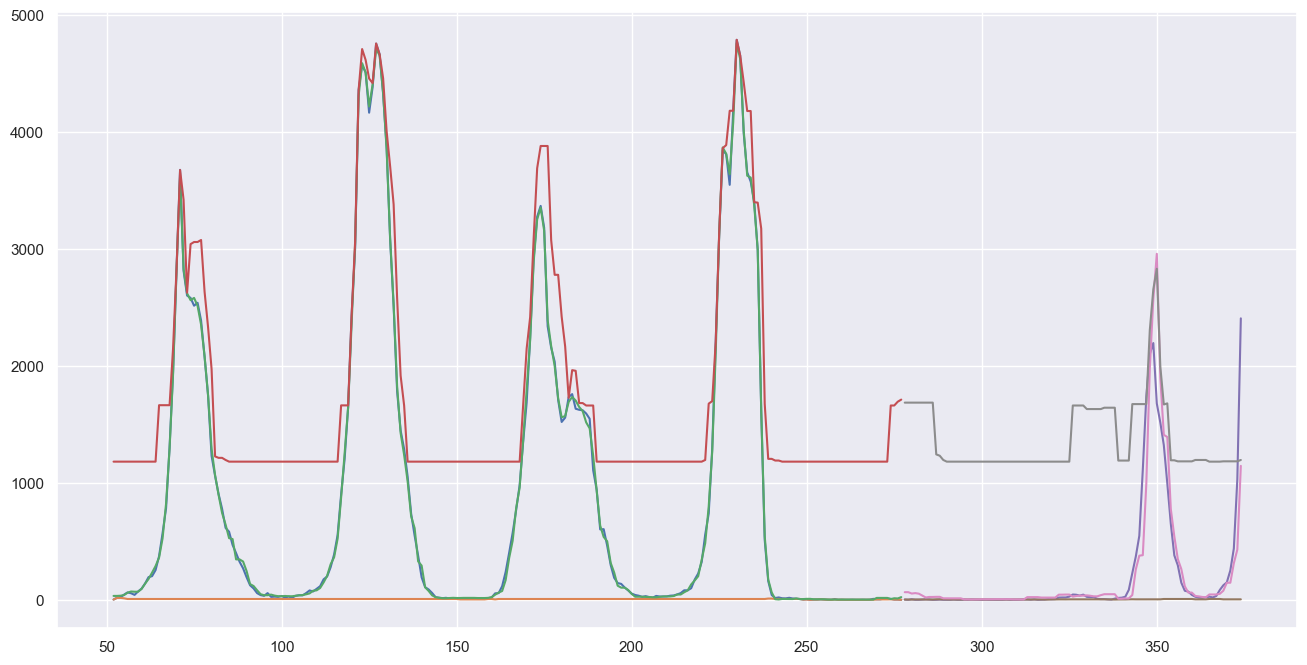

In [12]:
plt.figure()
plt.plot(predictions_train)
plt.plot(predictions_test)
# plt.plot(df.index[:train_size], preds_train_df[target], color='green', label='Training Set Predictions')
# plt.plot(df.index[train_size:], preds_test_df[target], color='red', label='Test Set Predictions')
# plt.title(f'{dataset} {week}-Week Ahead Influenza Predictions')
# plt.xlabel('Date')
# plt.ylabel('Cases')
# plt.legend()

In [13]:
def plot_intervals(predictions, mid=False, start=None, stop=None, title=None):
    """
    https://github.com/WillKoehrsen/Data-Analysis/blob/master/prediction-intervals/prediction_intervals.ipynb
    Function for plotting prediction intervals as filled area chart.
    
    :param predictions: dataframe of predictions with lower, upper, and actual columns (named for the target)
    :param whether to show the mid prediction
    :param start: optional parameter for subsetting start of predictions
    :param stop: optional parameter for subsetting end of predictions
    :param title: optional string title
    
    :return fig: plotly figure
    """
    # Subset if required
    predictions = (
        predictions.loc[start:stop].copy()
        if start is not None or stop is not None
        else predictions.copy()
    )
    data = []

    # Lower trace will fill to the upper trace
    trace_low = go.Scatter(
        x=predictions.index,
        y=predictions["lower"],
        fill="tonexty",
        line=dict(color="darkblue"),
        fillcolor="rgba(173, 216, 230, 0.4)",
        showlegend=True,
        name="lower",
    )
    # Upper trace has no fill
    trace_high = go.Scatter(
        x=predictions.index,
        y=predictions["upper"],
        fill=None,
        line=dict(color="orange"),
        showlegend=True,
        name="upper",
    )
    # Must append high trace first so low trace fills to the high trace
    data.append(trace_high)
    data.append(trace_low)
    
    if mid:
        trace_mid = go.Scatter(
        x=predictions.index,
        y=predictions["mid"],
        fill=None,
        line=dict(color="green"),
        showlegend=True,
        name="mid",
    )
        data.append(trace_mid)

    # Trace of actual values
    trace_actual = go.Scatter(
        x=predictions.index,
        y=predictions["actual"],
        fill=None,
        line=dict(color="black"),
        showlegend=True,
        name="actual",
    )
    data.append(trace_actual)

    # Layout with some customization
    layout = go.Layout(
        height=600,
        width=1200,
        title=dict(text="Prediction Intervals" if title is None else title),
        yaxis=dict(title=dict(text="Cases")),
        xaxis=dict(
            rangeselector=dict(
                buttons=list(
                    [
                        dict(count=1, label="1d", step="day", stepmode="backward"),
                        dict(count=7, label="1w", step="day", stepmode="backward"),
                        dict(count=1, label="1m", step="month", stepmode="backward"),
                        dict(count=1, label="YTD", step="year", stepmode="todate"),
                        dict(count=1, label="1y", step="year", stepmode="backward"),
                        dict(step="all"),
                    ]
                )
                ),
            rangeslider=dict(visible=True),
            type="date",
        ),
    )

    fig = go.Figure(data=data, layout=layout)

    # Make sure font is readable
    fig["layout"]["font"] = dict(size=15)
    fig.layout.template = "plotly_white"
    return fig

In [14]:
train_size = int(len(df_to_plot) *.7)
test_size = len(df_to_plot) - train_size

In [15]:
predictions_train['date'] = df_to_plot['Week Ending'].iloc[0:train_size]
predictions_test['date'] = df_to_plot['Week Ending'].iloc[train_size:len(df_to_plot)]

In [16]:
predictions_train = predictions_train.set_index('date')
predictions_test = predictions_test.set_index('date')

In [17]:
predictions_test

,actual,lower,mid,upper
date,,,,
2021-01-02,2.0,1.979927,65.061516,1686.226971
2021-01-09,0.0,1.979927,65.061516,1686.226971
2021-01-16,5.0,1.890354,53.417792,1686.226971
2021-01-23,0.0,2.510129,57.090945,1686.226971
2021-01-30,0.0,2.444890,52.379241,1686.226971
...,...,...,...,...
2022-10-08,149.0,3.839902,145.867601,1184.231468
2022-10-15,251.0,3.839902,145.867601,1184.231468
2022-10-22,438.0,3.839902,312.103626,1184.231468


In [18]:
predictions_train

,actual,lower,mid,upper
date,,,,
2016-09-03,2.0,2.000297,33.167223,1181.521424
2016-09-10,18.0,15.831784,33.167223,1181.521424
2016-09-17,23.0,16.089784,34.866208,1181.521424
2016-09-24,44.0,12.603177,40.285033,1181.521424
2016-10-01,63.0,6.797940,60.480550,1181.521424
...,...,...,...,...
2020-11-28,10.0,3.384408,16.065948,1181.521424
2020-12-05,8.0,4.032686,6.152239,1661.649758
2020-12-12,2.0,1.994088,13.073754,1661.649758


In [19]:
plot_intervals(predictions=predictions_train, start="2016-09-03", stop="2020-12-26", mid=True, title='Influenza Case Predictions - Training Set')

In [20]:
# plt.figure()
# plt.plot(predictions_train)
# plt.plot(predictions_test)

plot_intervals(predictions=predictions_test, start="2020-10-03", stop="2022-12-03", mid=True, title='Influenza Case Predictions - Test Set')

,Model,Dataset,Weeks-ahead Forecast,MSE_train,MSE_test,RMSE_train,RMSE_test,MAE_train,MAE_test,R2_train,R2_test
0,RF_test_2,Full Dataset,1,9026.51,415430.72,95.01,644.54,49.7,434.11,0.994843,-0.59194
0,RF_test_2,Full Dataset,2,12579.2,623953.6,112.16,789.91,57.12,538.03,0.992813,-0.492822
0,RF_test_2,Full Dataset,3,11496.91,944775.26,107.22,972.0,54.51,658.07,0.993432,-0.362659
0,RF_test_2,Full Dataset,4,12663.29,1495838.86,112.53,1223.04,56.55,823.48,0.992766,-0.187358
0,RF_test_2,Full Dataset,1,9026.51,415430.72,95.01,644.54,49.7,434.11,0.994843,-0.59194
0,RF_test_2,Full Dataset,2,12579.2,623953.6,112.16,789.91,57.12,538.03,0.992813,-0.492822
0,RF_test_2,Full Dataset,3,11496.91,944775.26,107.22,972.0,54.51,658.07,0.993432,-0.362659
0,RF_test_2,Full Dataset,4,12663.29,1495838.86,112.53,1223.04,56.55,823.48,0.992766,-0.187358
0,RF_test_2,Full Dataset,1,9026.51,415430.72,95.01,644.54,49.7,434.11,0.994843,-0.59194
0,RF_test_2,Full Dataset,2,12579.2,623953.6,112.16,789.91,57.12,538.03,0.992813,-0.492822


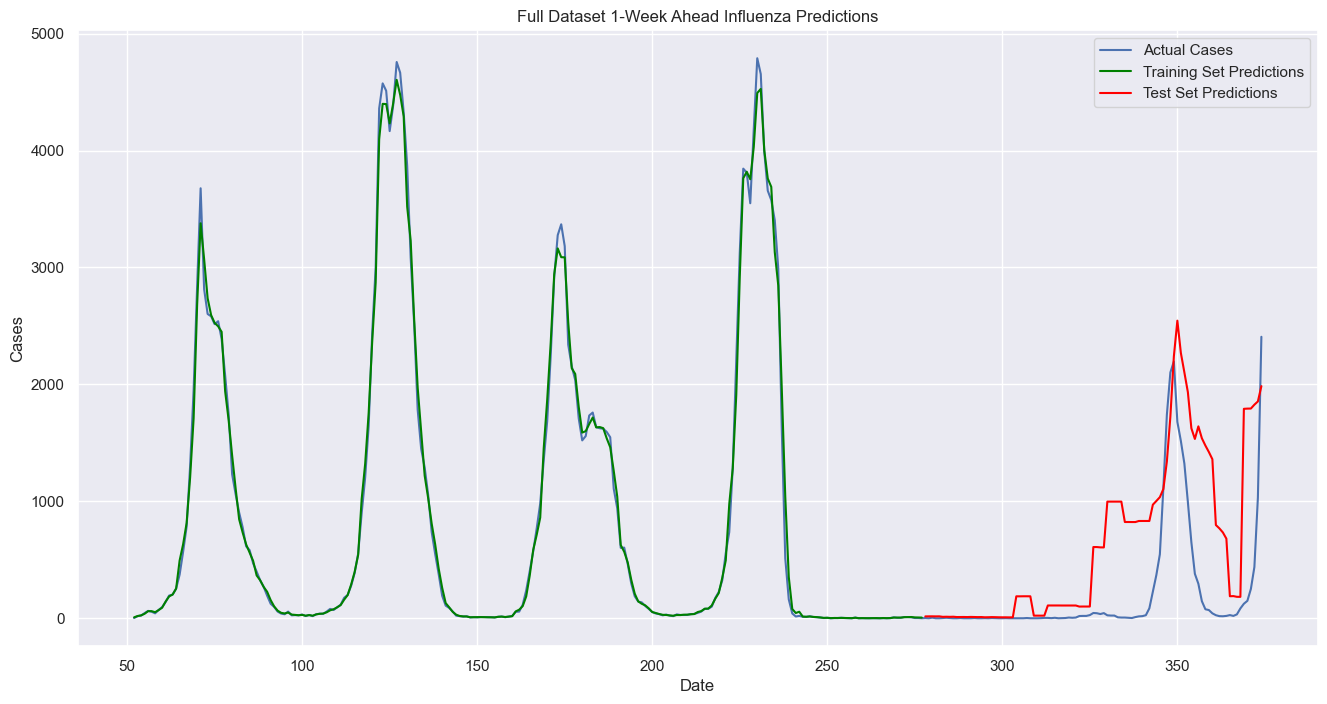

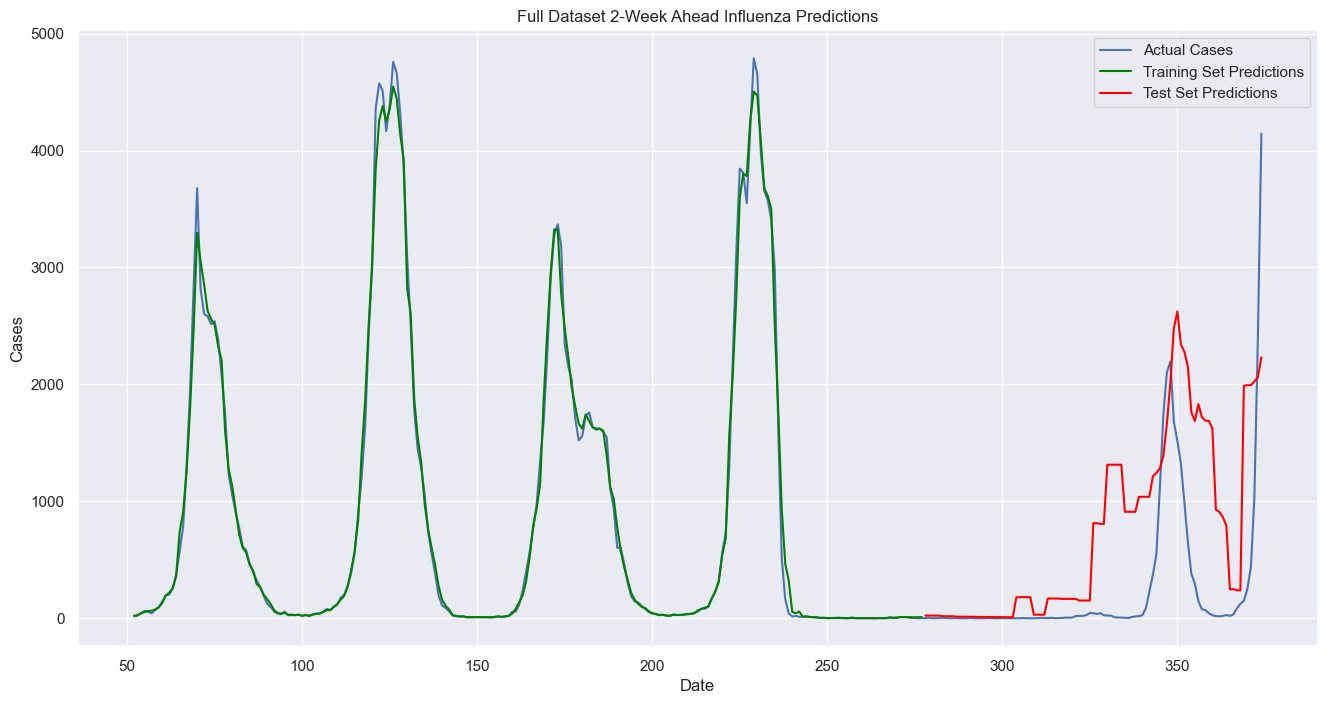

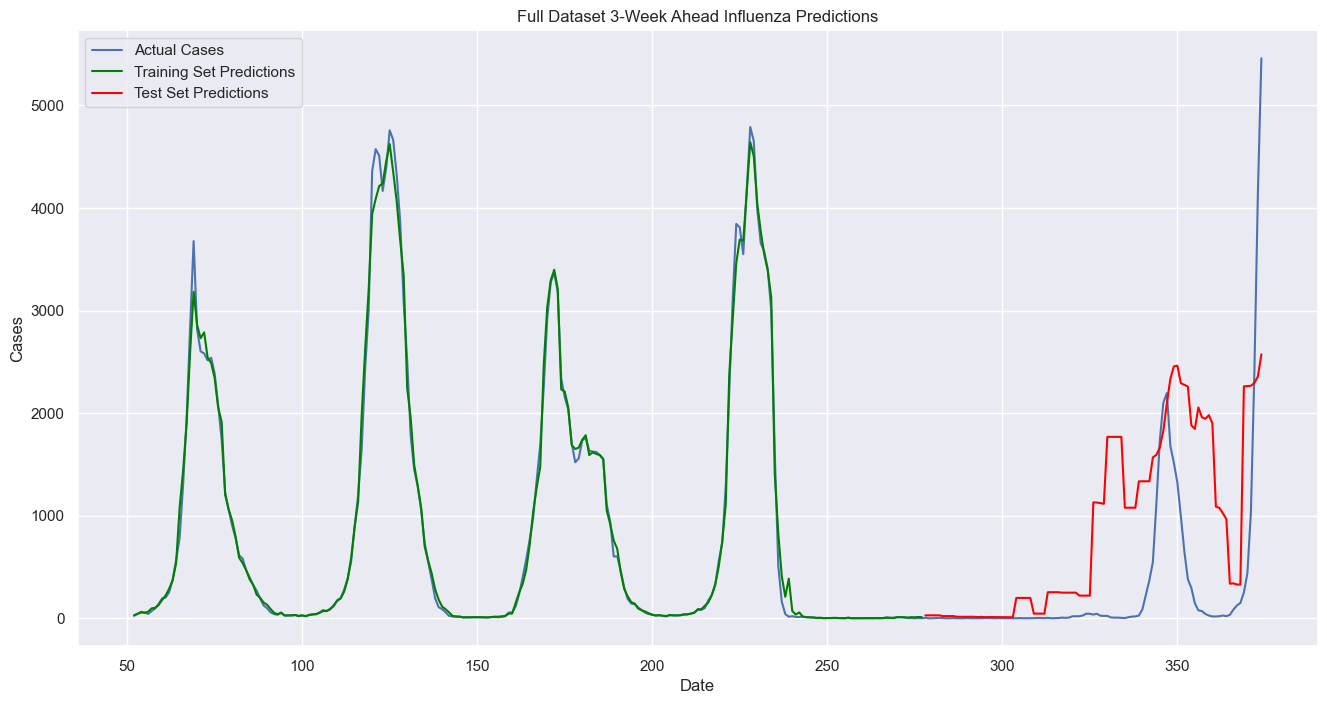

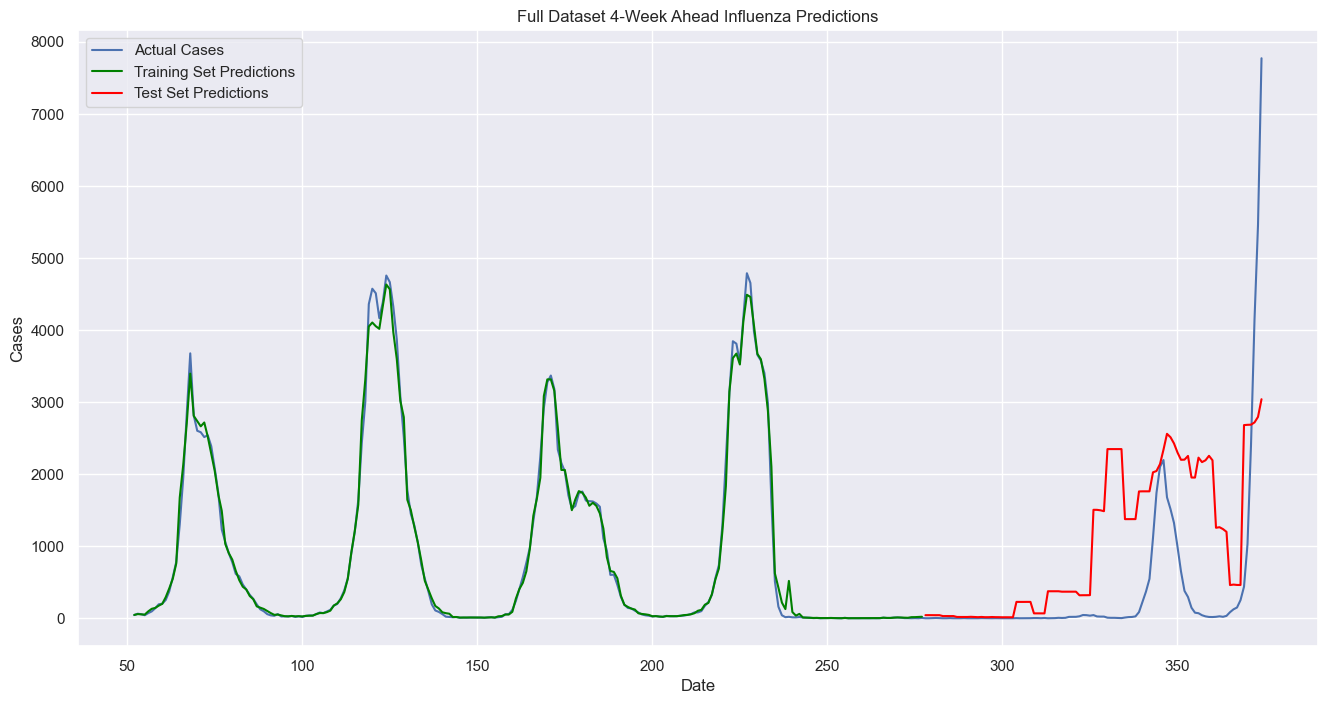

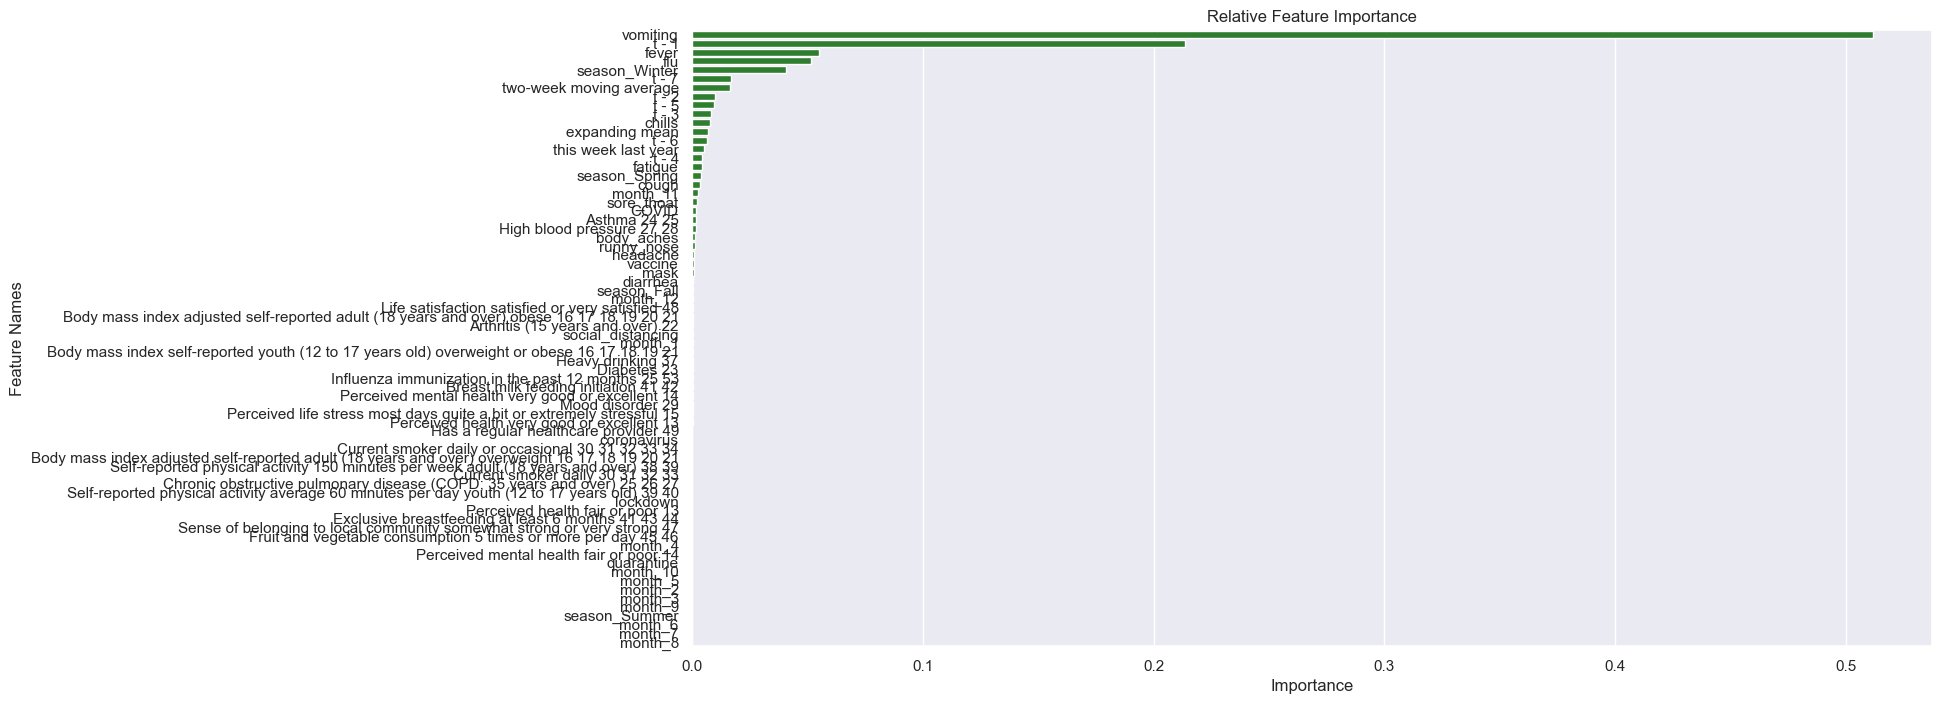

In [150]:
numeric_transform = Pipeline([('scaling', MinMaxScaler())])

categorical_transform = Pipeline([('one-hot-encode', OneHotEncoder(sparse=False))])

ct = make_column_transformer(
    (categorical_transform, cat_feats),
    (numeric_transform, num_feats),   
    remainder='passthrough')

pipeline = Pipeline(steps=[('preprocessing', ct), 
                          ('model', RandomForestRegressor(random_state=2023))])

pipeline.fit(train_X, train_y)

preds_test = pipeline.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = pipeline.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

dataset = 'Full Dataset'
model = 'RF_test_2'

for i in range(1,5):
    results_matrix = evaluate_model(train=train_y, test=test_y, preds_train=preds_train, preds_test=preds_test, dataset=dataset, forecast_weeks=i, model=model)

# plot
week = 1
for target in preds_train_df.columns:
    plt.figure()
    plt.plot(df.index, df[target].values, label='Actual Cases')
    plt.plot(df.index[:train_size], preds_train_df[target], color='green', label='Training Set Predictions')
    plt.plot(df.index[train_size:], preds_test_df[target], color='red', label='Test Set Predictions')
    plt.title(f'{dataset} {week}-Week Ahead Influenza Predictions')
    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.legend()
    week += 1

# get feature importances from the model
# referenced https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
importance = pipeline.steps[1][1].feature_importances_
names = pipeline[:-1].get_feature_names_out()

df = pd.DataFrame({'Feature Names':names,'Importance':importance, })
df = df.sort_values(by='Importance', ascending = False)
df[['dtype','Feature Names']] = df['Feature Names'].str.split("__",expand=True)
df = df.drop(columns='dtype')
plt.figure()
sns.barplot(data=df, x='Importance', y='Feature Names', orient='h', color='forestgreen').set(title='Relative Feature Importance')

results_matrix

## Forecast

In [157]:
preds_future = pipeline_mid.predict(df_to_predict)
preds_future_df = pd.DataFrame(np.round(preds_future),columns=[test_y.columns[0]])
# preds_future_df = preds_future_df.rename(columns={'y1':'1-Week Forecast','y2':'2-Week Forecast','y3':'3-Week Forecast','y4':'4-Week Forecast'})

df_flu = pickle.load(open(r"..\data\flu_cases\df_flu_total.pkl", "rb" ))
dates = df_flu.index

from datetime import timedelta
dates = dates + timedelta(weeks=3)

In [160]:
preds_future_df

,y1
0,3810.0


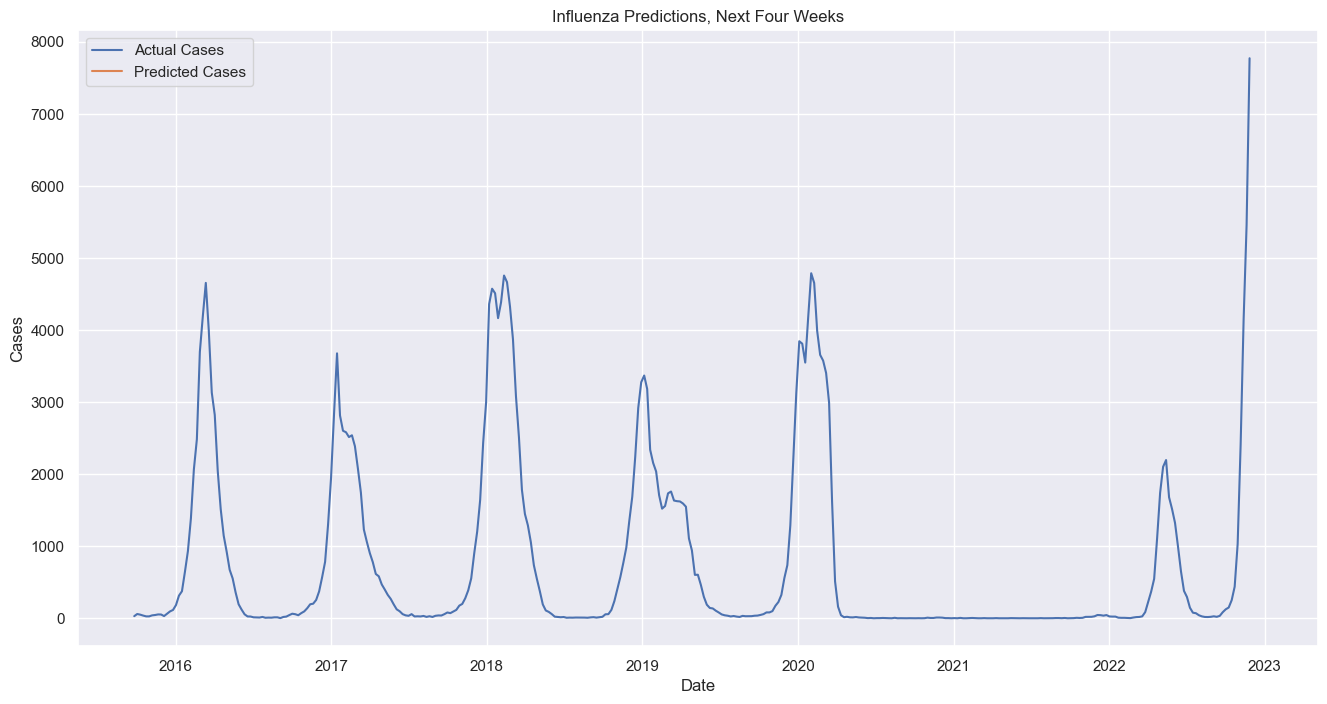

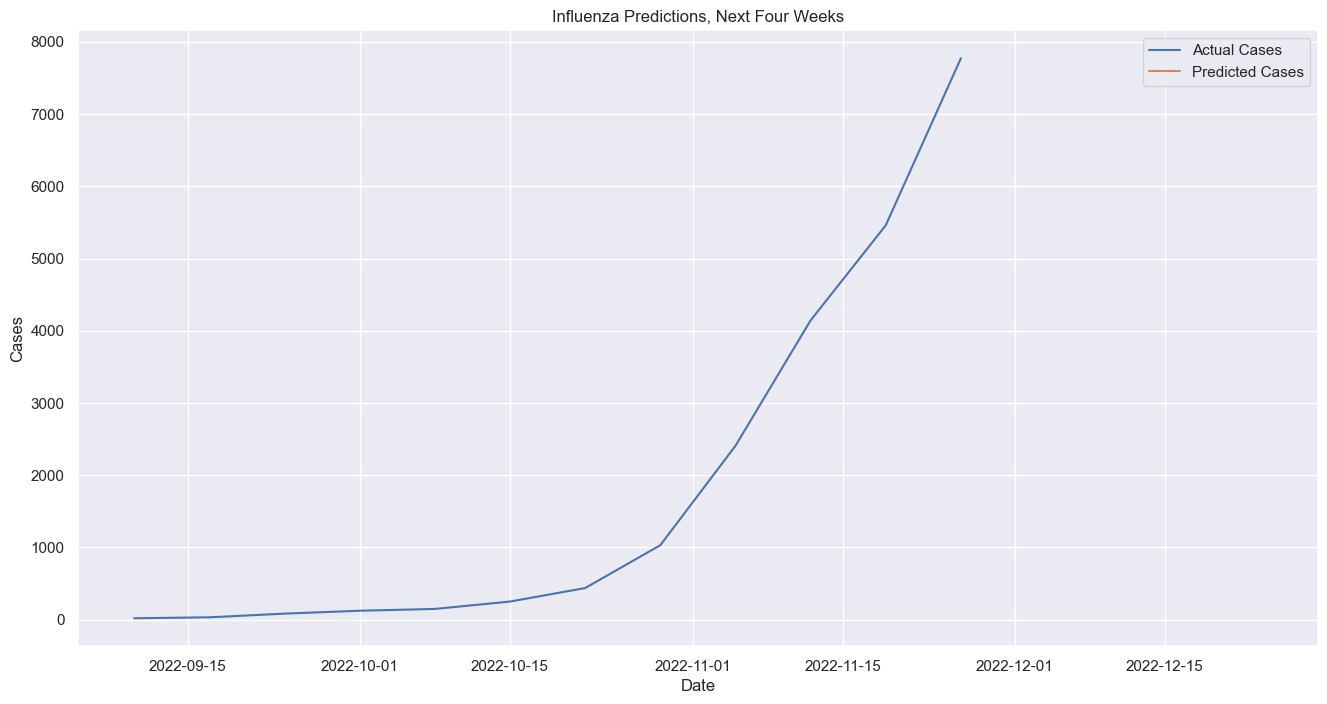

In [159]:
# all dates
plt.figure()
plt.plot(dates[:-4], df_flu[3:-1].values, label='Actual Cases')
plt.plot(dates[-1], preds_future_df.values, label='Predicted Cases')
plt.title(f'Influenza Predictions, Next Four Weeks')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()

# zoom plot
plt.figure()
plt.plot(dates[-16:-4], df_flu.iloc[-13:-1].values, label='Actual Cases')
plt.plot(dates[-1], preds_future_df.values, label='Predicted Cases')
plt.title(f'Influenza Predictions, Next Four Weeks')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()